In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df2004 = pd.read_csv('crime_incident_data2004.csv')
df2005 = pd.read_csv('crime_incident_data2005.csv')
df2014 = pd.read_csv('crime_incident_data2014.csv')
df2015 = pd.read_csv('crime_incident_data2015.csv')

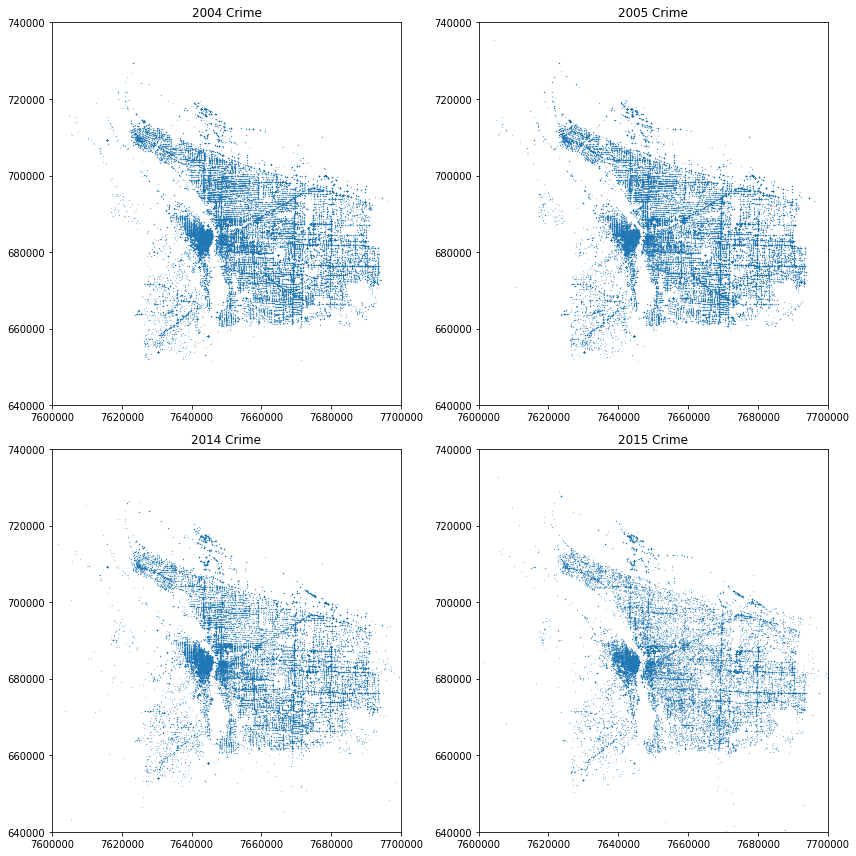

In [36]:
plt.figure(figsize=(12,12))
years = [2004, 2005, 2014, 2015]

plt.subplot(2,2,1)
plt.scatter(df2004['X Coordinate'], df2004['Y Coordinate'], s = .02)
plt.xlim(7600000, 7700000)
plt.ylim(640000, 740000)
plt.title('2004 Crime')

plt.subplot(2,2,2)
plt.scatter(df2005['X Coordinate'], df2005['Y Coordinate'], s = .02)
plt.xlim(7600000, 7700000)
plt.ylim(640000, 740000)
plt.title('2005 Crime')

plt.subplot(2,2,3)
plt.scatter(df2014['X Coordinate'], df2014['Y Coordinate'], s = .02)
plt.xlim(7600000, 7700000)
plt.ylim(640000, 740000)
plt.title('2014 Crime')

plt.subplot(2,2,4)
plt.scatter(df2015['Open Data X'], df2015['Open Data Y'], s = .02)
plt.xlim(7600000, 7700000)
plt.ylim(640000, 740000)
plt.title('2015 Crime')

plt.tight_layout()
plt.show()

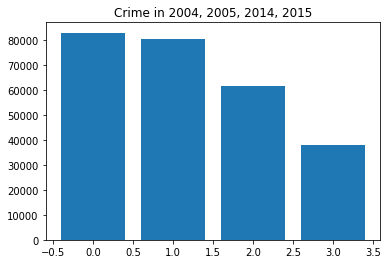

In [42]:
plt.bar(range(4), [len(df2004), len(df2005), len(df2014), len(df2015)])
plt.title('Crime in 2004, 2005, 2014, 2015')

plt.show()